# Training CNN-RF Model on Augmented Data

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
import joblib

2024-12-11 00:51:55.424423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import the Dataset

In [2]:
# Import Processed Dataset
data = "The IQ-OTHNCCD lung cancer dataset"

In [3]:
# Define class labels and dictionary for encoding
classes = {'Bengin cases', 'Malignant cases', 'Normal cases'}
label_dict = {"Bengin cases": 0, "Malignant cases": 1, "Normal cases": 2}

# Initialize lists for images and labels
images = []
labels = []
image_size = 224

In [4]:
# Loop through each class and load images
for class_name in classes:
    class_dir = os.path.join(data, class_name)
    for filename in os.listdir(class_dir):
        image_path = os.path.join(class_dir, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        images.append(image)
        labels.append(label_dict[class_name])

# Convert images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [5]:
# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.30, random_state=123, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=123, stratify=y_temp)

print(f"Training data size: {len(X_train)}")
print(f"Validation data size: {len(X_val)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 767
Validation data size: 221
Testing data size: 109


In [6]:
# Shape of Dataset
X_train.shape, X_test.shape, X_val.shape

((767, 224, 224, 3), (109, 224, 224, 3), (221, 224, 224, 3))

In [7]:
# Normalize the pixel values to range [0, 1]
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

In [8]:
# Check class distribution
train_class_counts = Counter(y_train)
val_class_counts = Counter(y_val)
test_class_counts = Counter(y_test)

print("Training class distribution:", train_class_counts)
print("Validation class distribution:", val_class_counts)
print("Testing class distribution:", test_class_counts)

Training class distribution: Counter({1: 392, 2: 291, 0: 84})
Validation class distribution: Counter({1: 113, 2: 84, 0: 24})
Testing class distribution: Counter({1: 56, 2: 41, 0: 12})


## Training the CNN-RF Model

In [9]:
# Initialize HeNormal for weight initialization
initialize = keras.initializers.HeNormal(seed=123)

# Define the CNN model
cnn_model = keras.models.Sequential([
    # First Convolutional Block
    layers.Conv2D(128, (5, 5), strides=(2, 2), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPool2D((3, 3), strides=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer=initialize,
                  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPool2D((2, 2), strides=(1, 1)),

    # Third Convolutional Block
    layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer=initialize,
                  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPool2D((2, 2), strides=(1, 1)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5, seed=123),

    # Output Layer
    layers.Dense(3, activation='softmax')  # 3 output classes
])

# Print the model summary
cnn_model.summary()

2024-12-11 00:54:18.347769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 52, 52, 32)       0

In [10]:
# Compile the model
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [11]:
# Train the model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    shuffle=True
)

Epoch 1/50
48/48 [==============================] - 20s 409ms/step - loss: 2.5251 - accuracy: 0.5645 - val_loss: 1.6284 - val_accuracy: 0.6878
Epoch 2/50
48/48 [==============================] - 19s 388ms/step - loss: 1.3945 - accuracy: 0.7588 - val_loss: 1.0037 - val_accuracy: 0.8643
Epoch 3/50
48/48 [==============================] - 18s 384ms/step - loss: 0.9288 - accuracy: 0.8722 - val_loss: 0.7590 - val_accuracy: 0.9231
Epoch 4/50
48/48 [==============================] - 19s 388ms/step - loss: 0.7401 - accuracy: 0.9087 - val_loss: 0.6209 - val_accuracy: 0.9276
Epoch 5/50
48/48 [==============================] - 19s 387ms/step - loss: 0.6184 - accuracy: 0.9283 - val_loss: 0.6062 - val_accuracy: 0.9095
Epoch 6/50
48/48 [==============================] - 18s 380ms/step - loss: 0.5129 - accuracy: 0.9544 - val_loss: 0.4373 - val_accuracy: 0.9638
Epoch 7/50
48/48 [==============================] - 18s 378ms/step - loss: 0.3977 - accuracy: 0.9752 - val_loss: 0.3656 - val_accuracy: 0.9864

In [12]:
# Evaluate on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 [==============================] - 1s 177ms/step - loss: 0.0938 - accuracy: 0.9725
Test Loss: 0.0938
Test Accuracy: 0.9725


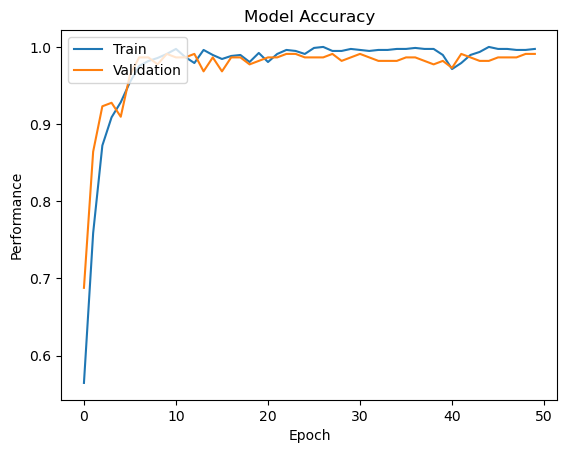

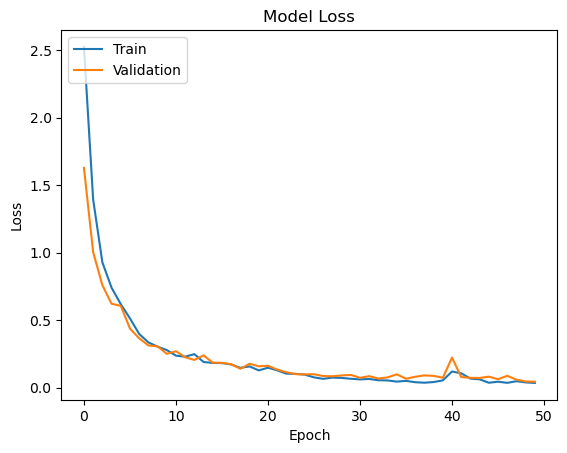

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
y_pred = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
print(classification_report(y_test, y_pred))

4/4 [==============================] - 1s 169ms/step
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.97      1.00      0.98        56
           2       0.97      0.95      0.96        41

    accuracy                           0.97       109
   macro avg       0.98      0.96      0.97       109
weighted avg       0.97      0.97      0.97       109



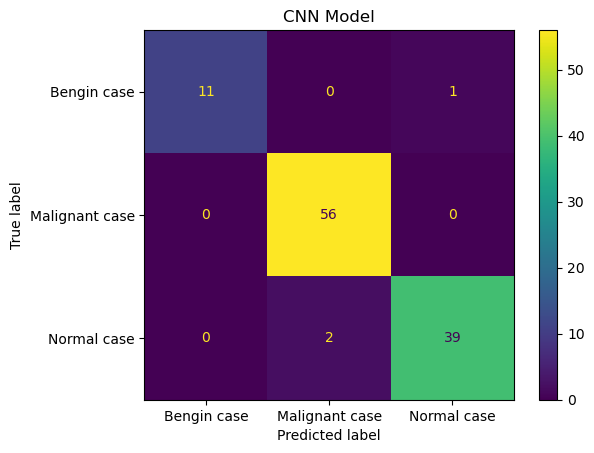

In [15]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels={'Bengin case':0, 'Malignant case':1, 'Normal case':2})
confusion_matrix_display.plot()
plt.title("CNN Model")
plt.show()

In [16]:
tensor = cnn_model.get_layer("conv2d").input
model_feat = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

In [17]:
model_feat.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 110, 110, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 32)        18464 

In [18]:
feature_extraction = model_feat.predict(X_train)

24/24 [==============================] - 5s 217ms/step


In [19]:
RF_X_Train = feature_extraction
RF_Model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, min_samples_split=2, max_depth=100,
                                 max_features='sqrt', random_state=7)
RF_Model.fit(RF_X_Train, y_train)

RandomForestClassifier(max_depth=100, random_state=7)

In [20]:
# Extract features from test data
RF_X_Test = model_feat.predict(X_test)
# Make predictions on test data
RF_Y_Pred = RF_Model.predict(RF_X_Test)
# Evaluate Performace
print(classification_report(y_test, RF_Y_Pred))

4/4 [==============================] - 1s 168ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       1.00      1.00      1.00        56
           2       0.95      1.00      0.98        41

    accuracy                           0.98       109
   macro avg       0.98      0.94      0.96       109
weighted avg       0.98      0.98      0.98       109



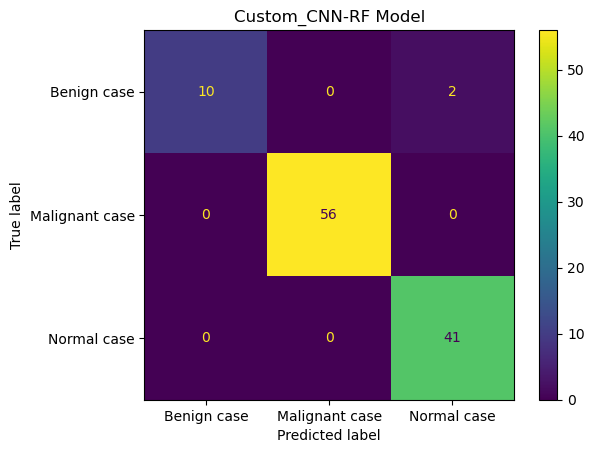

In [21]:
cm = metrics.confusion_matrix(y_test, RF_Y_Pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = {'Benign case':0, 'Malignant case':1, 'Normal case':2})

cm_display.plot()
plt.title("Custom_CNN-RF Model")
plt.show()

In [22]:
# Save the Model 
model_feat.save("Models/CNN-RF-Model.h5")
joblib.dump(RF_Model, "Models/RF_Model.pkl")

['Models/RF_Model.pkl']